# Project 20 - Predicting Insurance Costs

This project will be about linear regression modeling in Python. For this project, we'll be looking at the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

We are interested in how these different characteristics relate to the total medical cost. It's a continuous, positive number, which makes it a good candidate for a linear regression. <b>For this project, we want to construct the best possible predictive model for the cost, given some information about the patient</b>.

## Reading in the Data

In [16]:
#importing all the libraries we are going to use in this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [17]:
#reading in the data
insurance = pd.read_csv('insurance.csv')
print(insurance.shape)
insurance.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


From above we can see that there are 1338 rows and 7 columns. Each row contains one patient, with the following information:
- `age`: age of the patient in years
- `sex`: sex of the patient (female/male)
- `bmi`: bmi value for patient
- `children`: how manu children the patient has
- `smoker`: is the patient a smoker? (yes/no)
- `region`: the patient's residential area in the US (northeast, southeast, southwest, northwest)
- `charges`: individual medical costs billed by health insurance

## Exploring The Dataset

The column that we are interested in our predictions is `charges`. Next we are going to explore the dataset to find which variables are highly correlated with `charges`: the higher the correlation is, the better candidate the variable is for a predictive linear regression model. To calculate the correlations, we need to change the categorical columns to numerical columns. We are going to do the following:

- `sex`: female: 0, male: 1
- `smoker`: no: 0, yes: 1
- `region`: southwest: 0, southeast: 1, northwest: 2, northeast: 3

In [18]:
#removing future warning
pd.set_option('future.no_silent_downcasting', True)

insurance_copy = insurance.copy()
insurance_copy['sex'] = insurance['sex'].apply(lambda x: 1 if x == 'male' else 0)
insurance_copy['smoker'] = insurance['smoker'].apply(lambda y: 1 if y == 'yes' else 0)
#replace values
region_replace = {'southwest': 0,
                  'southeast': 1,
                  'northwest': 2,
                  'northeast': 3}
insurance_copy['region'] = insurance['region'].replace(region_replace)

insurance_copy.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,0,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,2,21984.47061
4,32,1,28.880,0,0,2,3866.85520


Above we modified the data to numerical values, so we can now get the correlations.

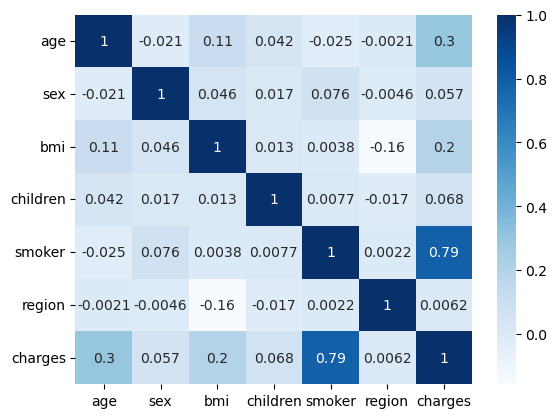

In [19]:
correlations = insurance_copy.corr()
#plotting correlation
sns.heatmap(correlations, annot=True, cmap="Blues")
plt.show()

From the heatmap above, we can see that the highest correlation with `charges` is with `smoker` (0.79). This is clearly the highest correlation, with the second highest being `age`, which has a correlation value of only 0.3.

### Histograms

Next we'll plot some histograms to see the distributions.

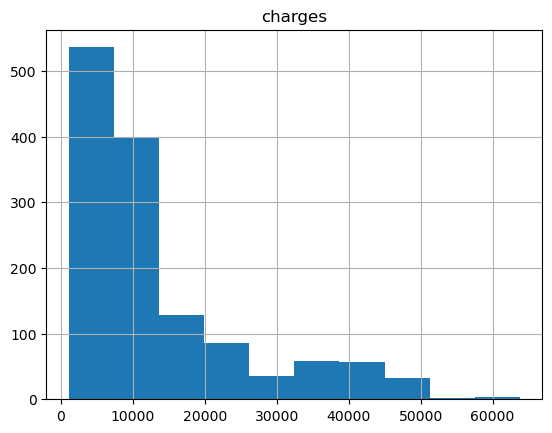

In [20]:
insurance_copy.hist('charges')
plt.show()

The `charges` histogram shows us that the data is highly skewerd to the right, meaning that there are more insurance costs between around 1000 and 15000 than there are very high charges. It might be worth it to log-transform the outcome, so let's try that.

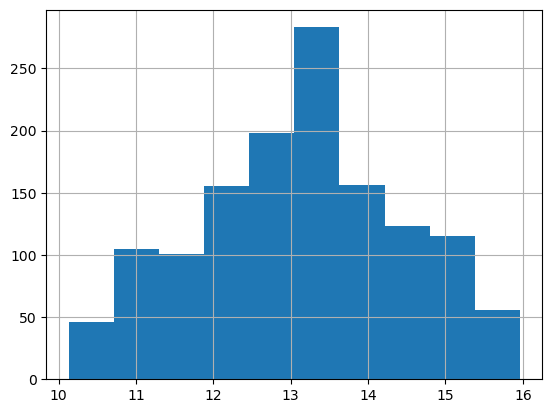

In [21]:
insurance_copy['log_charges'] = np.log2(insurance_copy['charges'])
insurance_copy['log_charges'].hist()
plt.show()

The log-transformed `charges` values are more centered (looking more like a normal distribution), which is what we want. This makes it more likely that the errors will be unbiased.

### Box Plots for Correlating Columns

Next we are going to box plot columns that had some correlation with `charges`.

#### Sex

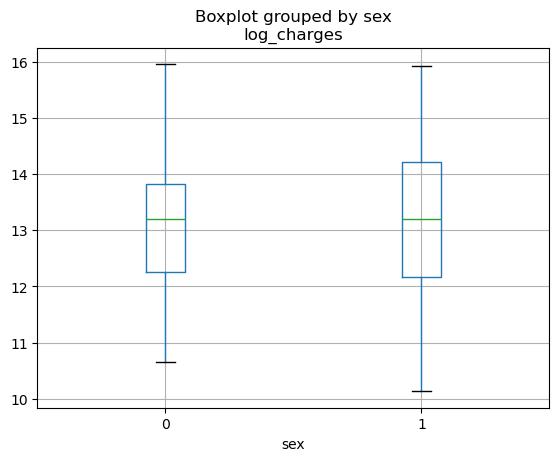

In [22]:
insurance_copy.boxplot(column=['log_charges'], by='sex')
plt.show()

Males (1) have a little bit wider distribution of charges compared to woman.

#### Smoker

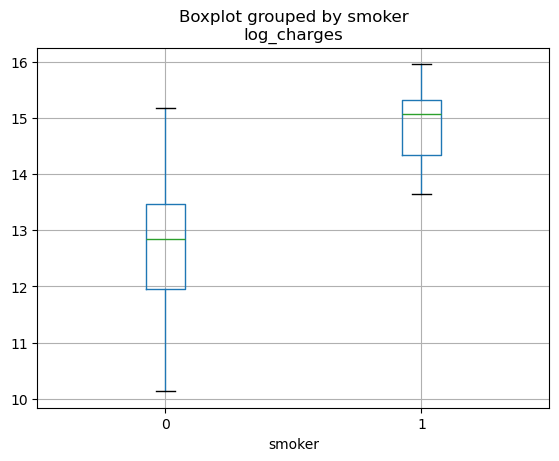

In [23]:
insurance_copy.boxplot(column=['log_charges'], by ='smoker')
plt.show()

Smokers have much higher charges than non-smokers.

#### Children

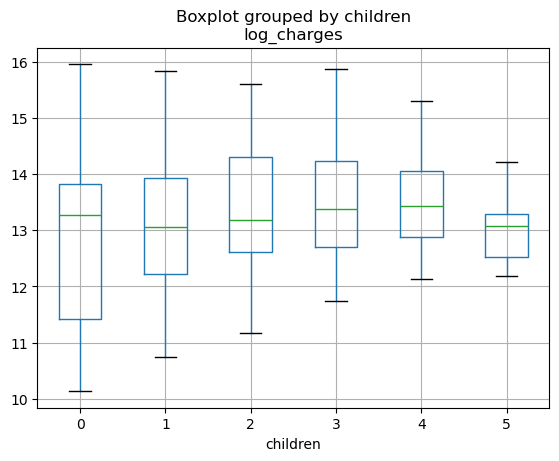

In [24]:
insurance_copy.boxplot(column=['log_charges'], by='children')
plt.show()

The average charges for each group based on the number of children are similar. However, patients with 0 children have the widest distribution of charges.

## Predictors

To estimate the predictors, we are going to use the top 3 correlated values:
- `smoker`
- `age`
- `bmi`

The `sex` and `children` columns have low differences in the box plots above, so we are not going to use them.

## Dividing The Data

Before building the model, we have to divide our data to a training set and a test set. We are going to use 80% of the dataset for training and 20% for testing.

In [25]:
#X = all the predictor columns
X = insurance_copy[['smoker', 'age', 'bmi']]
#y = the value we are predicting
y = insurance_copy['log_charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1)

## Building The Model

Now we are going to build our model and examine the regression coefficients and whether or not they make any sense considering their correlation with the outcome. We are also going to see how well the model predicts the medical costs in the training set.

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)
#coefs
coefficients = model.coef_
print(f'coefficients (smoker, age, bmi): {coefficients}')

#predictions
predictions = model.predict(X_train)
r_2 = r2_score(y_train, predictions)
print(f'r2_score: {r_2}')
mse = mean_squared_error(y_train, predictions)
print(f'mean squared error: {mse}')
#np.exp to change to the original scale from log
mse = np.exp(mean_squared_error(y_train, predictions))
print(f'original scale mean squared error: {mse}')


coefficients (smoker, age, bmi): [2.21807367 0.04983948 0.01422752]
r2_score: 0.7401147505859649
mean squared error: 0.4518841055670151
original scale mean squared error: 1.5712698365981916


Coefficients make sense considering their correlations. Coefficient 2.21 for smokers means, that being a smoker increases log_charges by 2.21 units on average. One more year of age increases log_charges by 0.05 USD, and each unit of BMI increases log_charges by 0.01 USD.

R2-score tells us that these 3 variables explain the variability of charges by approximately 74%. This is fairly high value, meaning that the model is fairly accurate.

Mean squared error for the model is 0.45 when using log_charges, and 1.57 when using original scale.

## Residual Diagnostics

Before we examine our model more closely, we'll check how well the assumptions of linear regression are met.

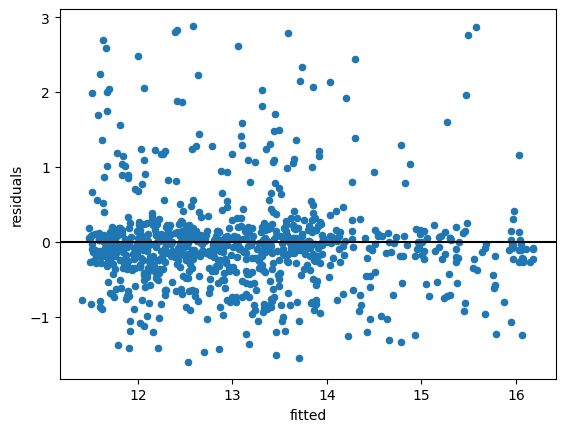

In [27]:
residual_check = pd.DataFrame()
residual_check['fitted'] = predictions
residual_check['residuals'] = y_train - predictions

residual_check.plot.scatter(x='fitted', y = 'residuals')
plt.axhline(0, color='black')
plt.show()

The residuals seem to center around 0, but there are also values that are fairly far from 0. The higher the fitted value is, the less there are residuals around 0. Overall this plot shows that the assumptions needed for linear regression are met - there is no clear clusters, no clear trends and not many outliers. Most of the dots are close to 0.

## Interpreting The Model

The formula for linear regression model is the following:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n + \epsilon $$

Let's take a look at our models values and what they mean.


In [28]:
print(model.intercept_)

10.287964914278959


The intercept (beta 0) for our model is 10.3, which means that when all the other variables are 0, the outcome y (log_charges) would be 10.3. This doesn't really tell us anything important about the outcome we want to predict, it just means that if all the other variables didn't exist the log_charges would be around 10.3, but in the real world the other variables always exist.

In [29]:
print(model.coef_)

[2.21807367 0.04983948 0.01422752]


Our coefficients were smoker, age, bmi. From above we can see that smoker has a value of 2.2, age has a value of 0.05 and bmi has a value of 0.01. 

Coefficients are the other betas in the formula. For example our linear regression model formula in this case looks like this:

$$ y = 10.28 + 2.2 smoker + 0.05 age + 0.01 bmi $$

This means that being a smoker adds 2.2 to the outcome. One year of age adds 0.05, so for example being 20 years old would add 1 to outcome. This same goes with bmi.

## Final Model Evaluation

The training error is almost always overly optimistic, so we shouldn't use it as the final judge of the model's predictive ability. To see how the model performs, we are going to use our test data. Test data means new observations, that the model hasn't been trained on, so if it is accurate with observations that it has never seen before, we can trust that it is accurate with new observations.

In [30]:
model.fit(X_test, y_test)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(mse)
print(np.exp(mse))

0.43220439190764903
1.5406499793704855


For the test set, we got a mean squared error of 0.43 for the log values, and 1.54 for original values. This means that our model actually has a little bit lower mean squared error with the test data than it had with the training data (0.45 and 1.57). These two match up pretty well, so we can conclude that the model is not overfit.

## Conclusion

In this project we used a linear regression model to estimate the insurance costs for medical bills. With our dataset we found the following linear regression model for log_charges:

$$ y = 10.28 + 2.2smoker + 0.05age + 0.01bmi $$

- The intercept is 10.28, meaning that log_charges are 10.28 without any variables
- Being a smoker adds 2.2 units to log_charges
- One year of age adds 0.05 to log_charges
- One unit of bmi adds 0.01 to log_charges

The residuals were fairly close to 0, meaning that the model is fairly balanced. With higher costs there were less residuals with a value close to 0, so the model is predicting lower costs for patients who were actually charged higher.